# Climate Change Tweet Classification

## Introduction

Kaggle is hosting a Climate Change Belief Analysis competition which aims to predict an individual's belief in climate change based on historical tweet data.

The results from the prediction will help companies better understand their customer's perception on climate change. Such an analysis or prediction will help companies determine how their products will be recieved; thus guiding their marketing strategy and their production processes. Providing a solution to this task will provide access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. The model will be deployed to the streamlit application which can be used remotely through the use of an AWS EC2 instance.

### Problem statement 

We are tasked to create a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their tweets.

Companies are looking to create products that are environmentally friendly. Thus they would like to understand their consumers' view on climate change. To address this, we are going to create Machine Learning models that are able to classify whether or not a person believes in climate change, based on their novel tweet data. Correct classification of a tweet will help companies understand consumer sentiment, which will further guide their business strategies.

## Table of Contents

1. Introduction
2. Importing Libraries
3. Importing Dataset
4. Data Preprocessing
5. Exploratory Data Analysis
6. Feature Engineering and Selection
7. Model Selection 
8. Model Evaluation
9. References

## Comet


Comet is a great tool for model versioning and experimentation as it records the parameters and conditions from each of the experiements- allowing for reproducing of results, or going back to a previous version of the experiment.

In [2]:
!pip install comet_ml

### Import Libraries

In [3]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180 # Quality of all figures in notebook
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install nlppreprocess

In [5]:
from nlppreprocess import NLP

## Data Collection

## Summary statistics

In [7]:
#Importing Dataset
Trainingdata = pd.read_csv("train.csv").fillna(' ')
Testdata = pd.read_csv("test_with_no_labels.csv").fillna(' ')

In [3]:
# Looking at the first few entries in the dataset
Trainingdata.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [4]:
Testdata.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [25]:
# Looking at the numbers of possible classes in our sentiment
Trainingdata['sentiment'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [23]:
# Shape of the dataset
Trainingdata.shape

(30759, 3)

In [24]:
# Looking at the how the messages are distributed across the sentiment
Trainingdata.describe()

,sentiment,tweetid
count,30759.000000,3.075900e+04
mean,0.853929,8.364330e+17
std,0.853551,8.519986e+16
min,-1.000000,5.926334e+17
25%,0.000000,7.970301e+17
50%,1.000000,8.401516e+17
75%,1.000000,8.996975e+17
max,2.000000,9.666876e+17


## Data Cleaning

This stage of Data Cleaning we will detect and correct corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data. This stage applies database normalization which is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. The aim is to improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints. 

stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

### Summary statistics

In [5]:
train_df = Trainingdata.copy()
test_df = Testdata.copy()

print('Dataset size:',train_df.shape)
print('Columns:',train_df.columns)

Dataset size: (15819, 3)
Columns: Index(['sentiment', 'message', 'tweetid'], dtype='object')


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


<AxesSubplot:xlabel='sentiment', ylabel='count'>

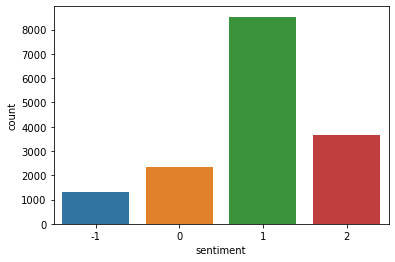

In [7]:
sns.countplot(x = 'sentiment', data = train_df)

Remove duplicate tweets

In [8]:
train_df = Trainingdata.drop_duplicates()
train_df.shape

(15819, 3)

In [9]:
train_df.tweetid.unique

<bound method Series.unique of 0        625221
1        126103
2        698562
3        573736
4        466954
          ...  
15814     22001
15815     17856
15816    384248
15817    819732
15818    806319
Name: tweetid, Length: 15819, dtype: int64>

Removing emojis

In [10]:
import emoji
import string

def remove_emoji(tweet_):
    characters = [str for str in tweet_]
    list_of_emoji = [i for i in characters if i in emoji.UNICODE_EMOJI]
    clean_tweet = ' '.join([str for str in tweet_.split() if not any(j in str for j in list_of_emoji)])
    return clean_tweet

In [11]:
tweets_list = []

for index, rows in train_df['message'].iteritems():
    rows =  remove_emoji(rows)
    tweets_list.append(rows)
    
train_df['message'] = tweets_list

Remove Line breaks, URL's, Numbers, Capital letters, & Punctuation

In [12]:
import re
import string


def tweet_preprocessor(tweet):
    tweet = tweet.replace('\n', ' ')                           # remove line breaks
    tweet = re.sub(r"\bhttps://t.co/\w+", '', tweet)           # remove URL's
    tweet = re.sub('\w*\d\w*', ' ', tweet)                     # remove numbers
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ',   
            tweet.lower())                                     # remove capital letters and punctuation
    return tweet

In [13]:
for i,row in train_df.iterrows():
    train_df.at[i,'message'] = tweet_preprocessor(row['message'])

In [14]:
train_df

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt rawstory researchers say we have three ye...,698562
3,1,todayinmaker wired was a pivotal year in...,573736
4,1,rt soynoviodetodas it s and a racist sex...,466954
...,...,...,...
15814,1,rt ezlusztig they took down the material on ...,22001
15815,2,rt washingtonpost how climate change could b...,17856
15816,0,notiven rt nytimesworld what does trump act...,384248
15817,-1,rt hey liberals the climate change crap is...,819732


In [31]:
#Tokenization -> chops each tweet into a collection of individual words (i.e. tokens)
#Lemmatization -> Aims to cut each word down to its base form 
                #(e.g. laugh, laughs, laughing, laughed would be reduced to laugh)
                #This reduces the complexity of analysis by reducing number of unique words

In [29]:
# Looking at the numbers of possible classes in our sentiment
Trainingdata['sentiment'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [28]:
# Looking at the how the messages are distributed across the sentiment
Trainingdata.describe()

,sentiment,tweetid
count,30759.000000,3.075900e+04
mean,0.853929,8.364330e+17
std,0.853551,8.519986e+16
min,-1.000000,5.926334e+17
25%,0.000000,7.970301e+17
50%,1.000000,8.401516e+17
75%,1.000000,8.996975e+17
max,2.000000,9.666876e+17


## Missing values

In [30]:
# Checking for missing values
Trainingdata.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [32]:
# Checking whether a character is white-space character or not
print(len(Trainingdata['message']))
print(sum(Trainingdata['message'].apply(lambda x: x.isspace())))

30759
0


In [33]:
# Sample tweet
tweet = Trainingdata.iloc[6,1]
print(tweet)

RT @T_S_P_O_O_K_Y: @beardoweird0 @20committee I actually have a degree in Environmental Studies - and yes - man made climate change is a ho…


Text(0.5, 1.0, 'Distribution of target labels')

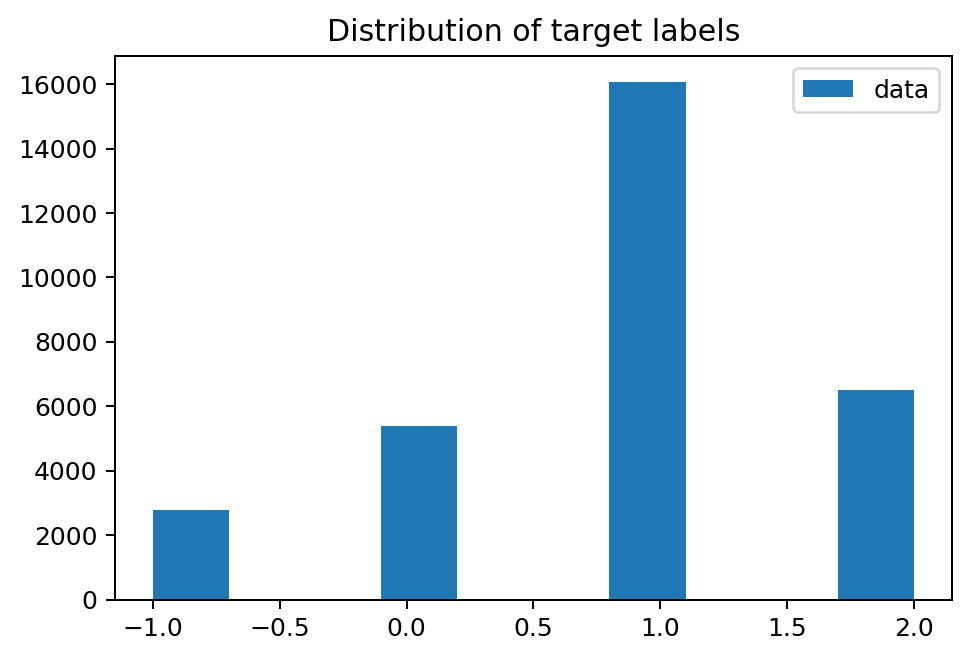

In [34]:
# Visualizing the distribution of the target 
plt.hist(Trainingdata['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

There is an imbalance of classes in the daset and which can cause a disproportionate ratio of observations in each class. This can cause inaccurate and erros to our algorithms are designed to maximize accuracy and reduce error. Therefore we will address the imbalance in our EDA.

Text(0, 0.5, 'Density')

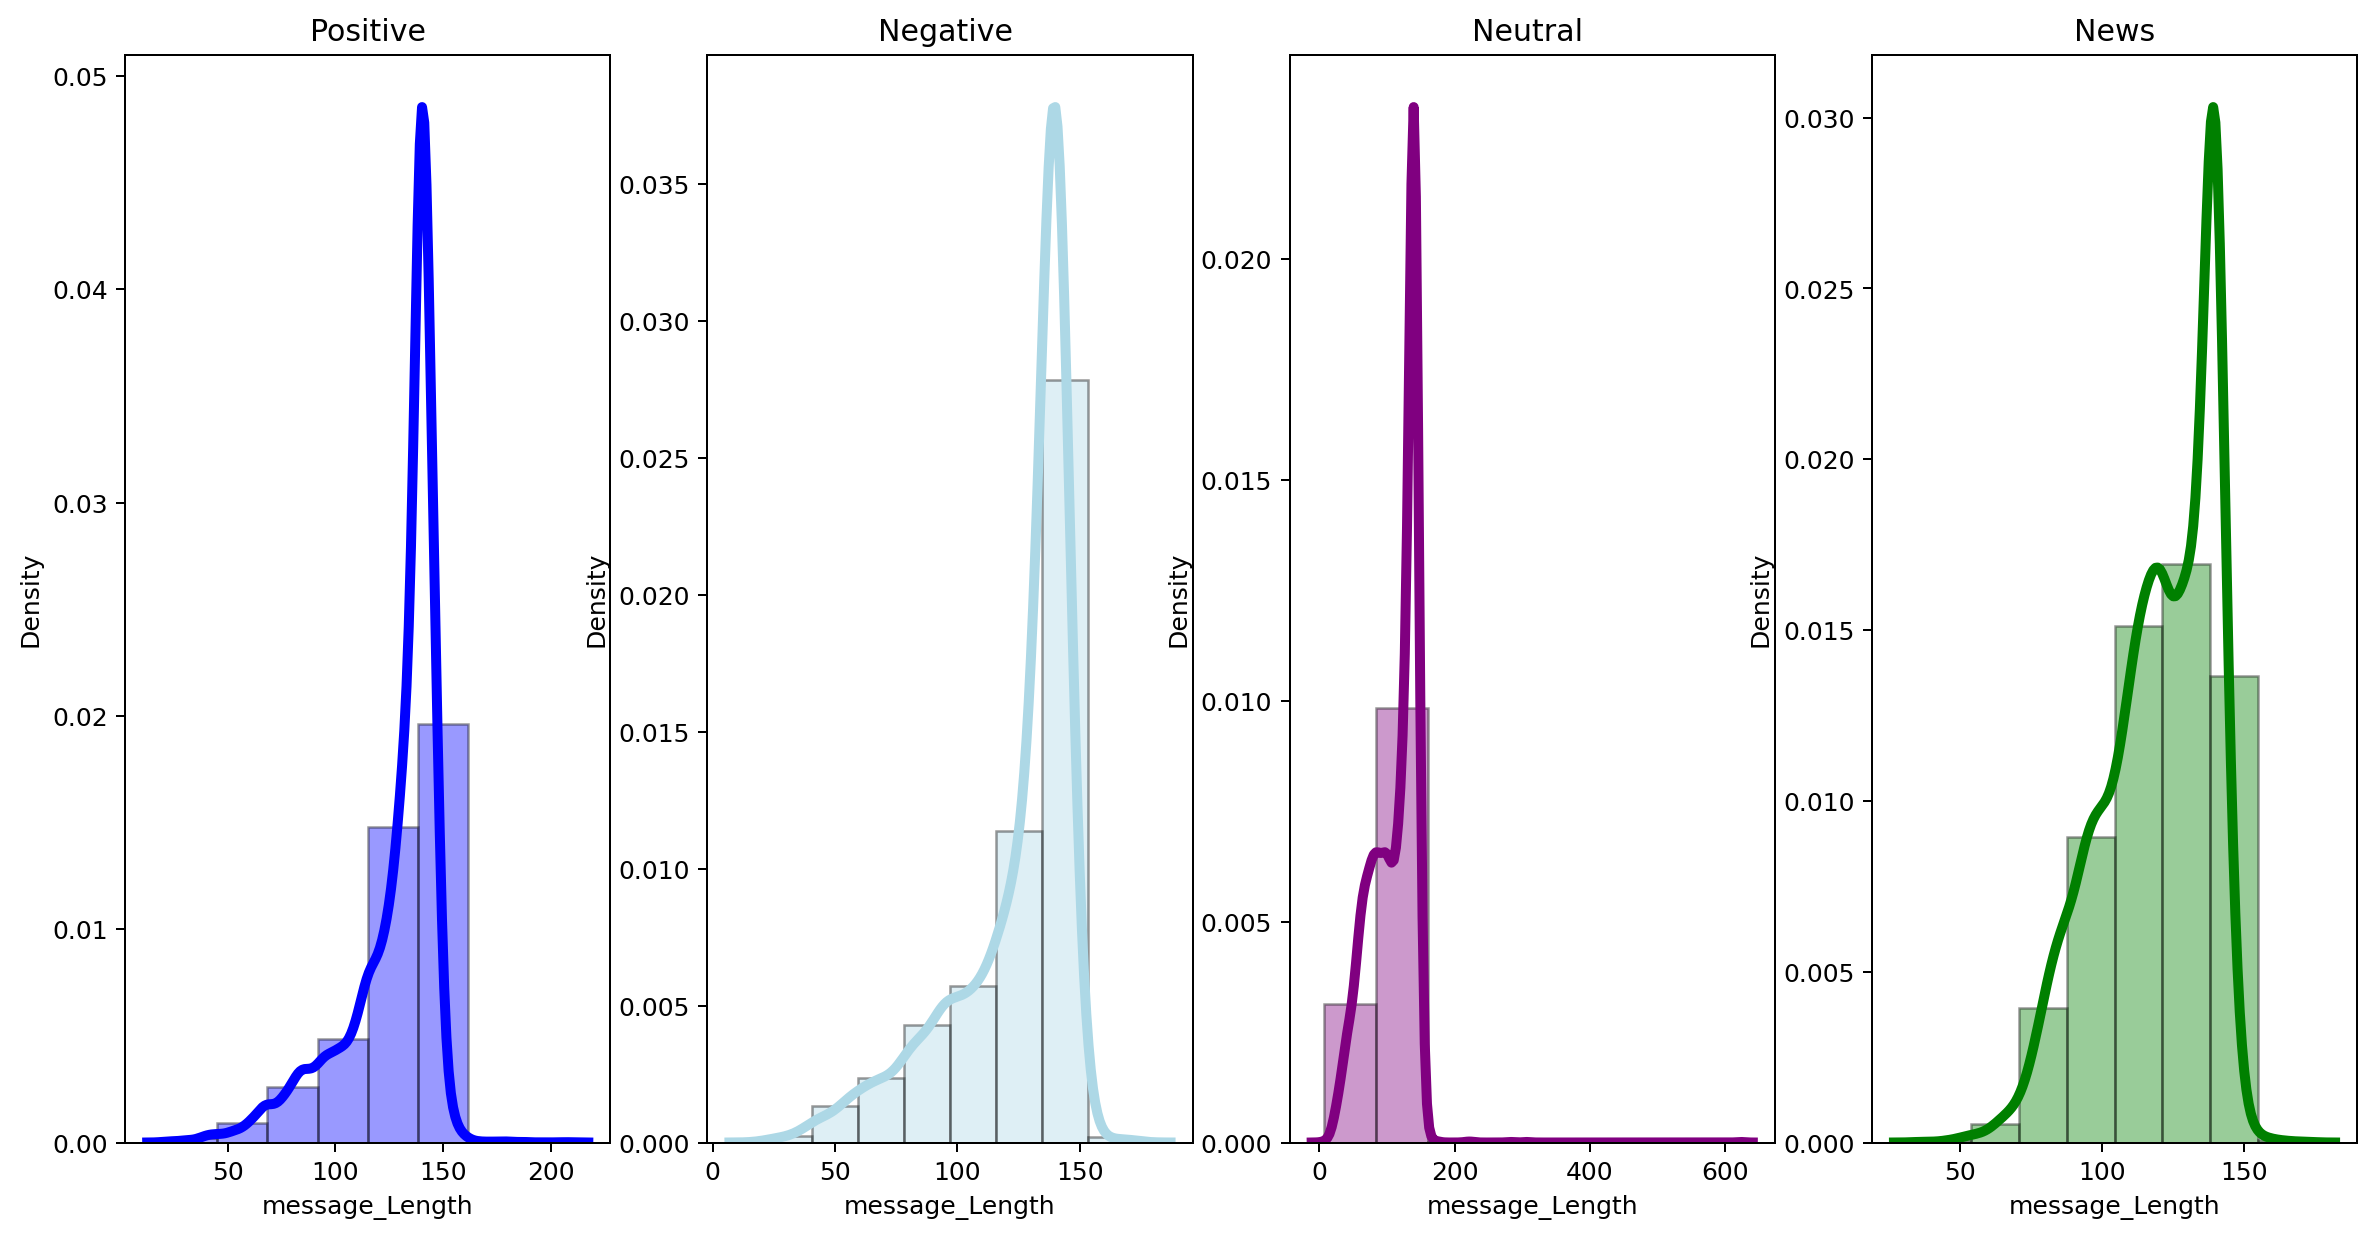

In [35]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(Trainingdata[Trainingdata['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(Trainingdata[Trainingdata['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(Trainingdata[Trainingdata['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(Trainingdata[Trainingdata['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

The average length of messages for all sentiments tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting and will make for more unpacking later in the EDA. Now that we have explored our dataset, we can begin perfoming some analyses on it.

##  Exploratory Data Analysis

The EDA performs investigative and detective analysis of our data to see if we can unearth any insights. we work on the text data. The data is being generated from tweets, digital media platforms, blogs, and a whole host of other sources. As a data scientists and an NLP enthusiasts, it’s important to analyze all this text data to help organizations make data-driven decisions.

In [8]:
working_df = Trainingdata.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

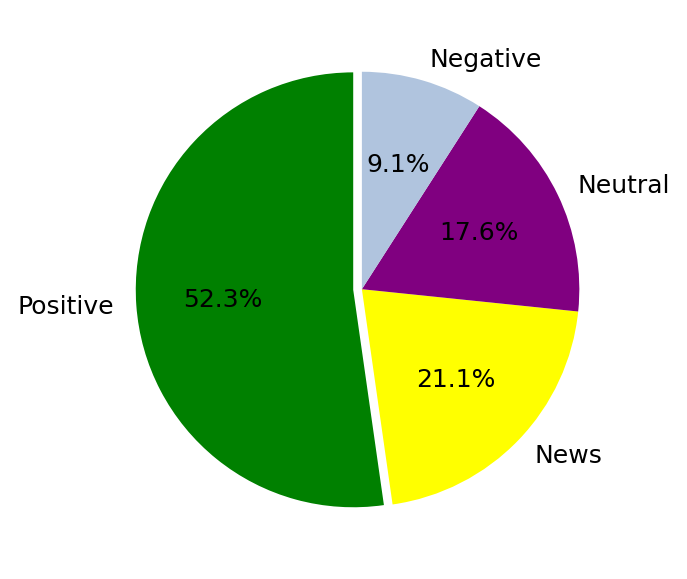

In [9]:
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['green', 'yellow', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

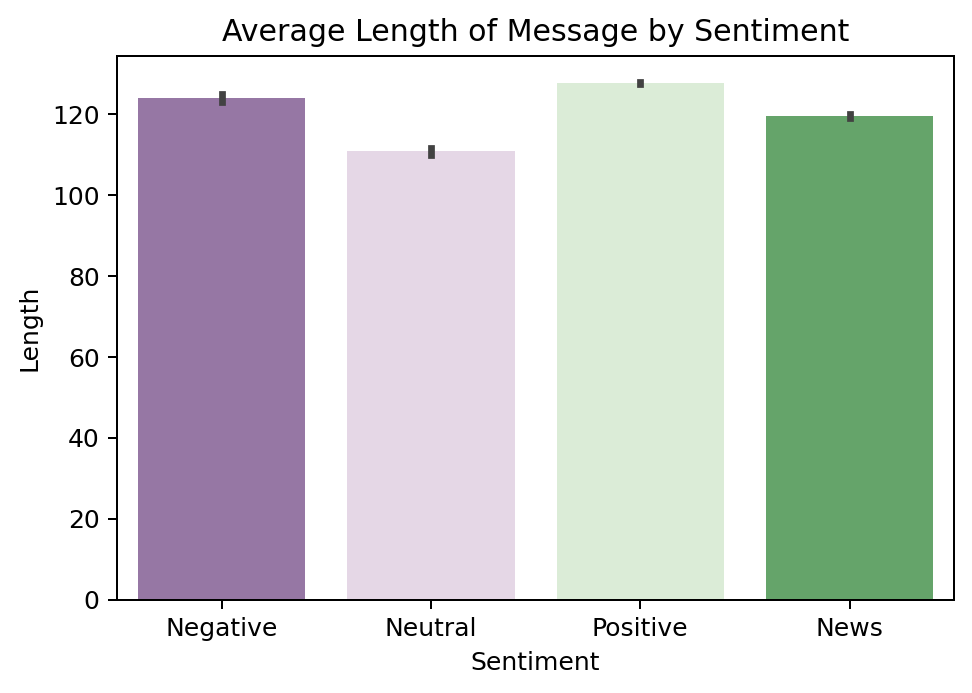

In [10]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

It can be noted that earlier there was an imbalance of classes in the daset, this can lead to a disproportionate ratio of observations in each class, causing problems as most algorithms are designed to maximize accuracy and reduce error. We therefore continue to analyse and evaluate for more insights to be derived from the dataset as we prepared to balance later on in the analysis.

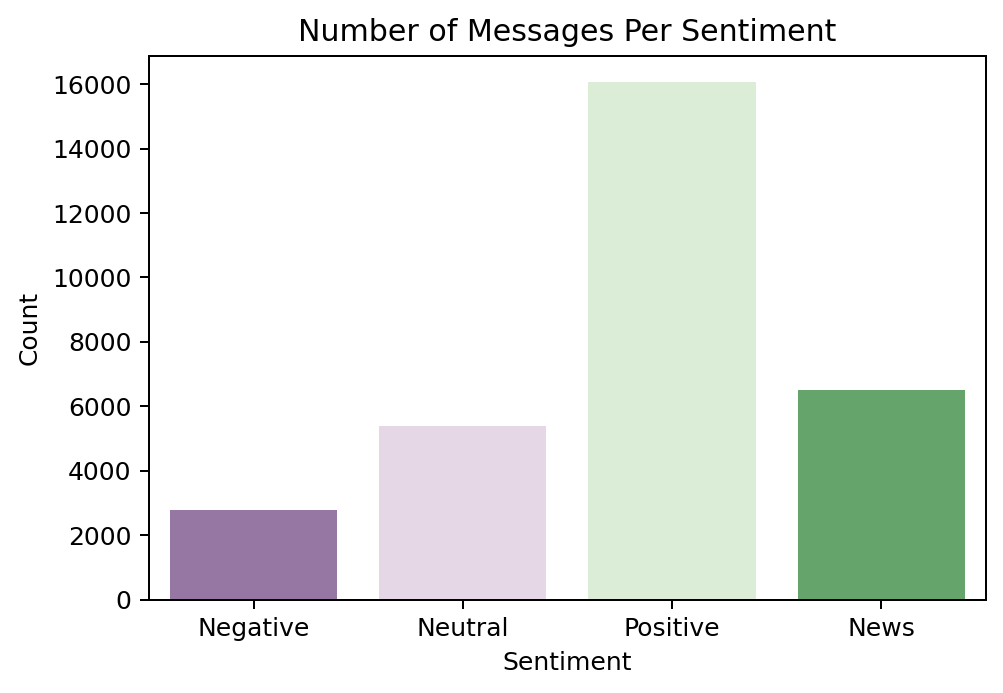

In [11]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

In [12]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in working_df.message]

# Creating a column of hastags
working_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in working_df.message]

In [13]:
# Generating Counts of users
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [14]:
# Top 5 most popular
counts.head()

,users,message
6286,@StephenSchlegel,362
6010,@SenSanders,312
11491,@realDonaldTrump,217
12324,@thehill,161
804,@BernieSanders,152


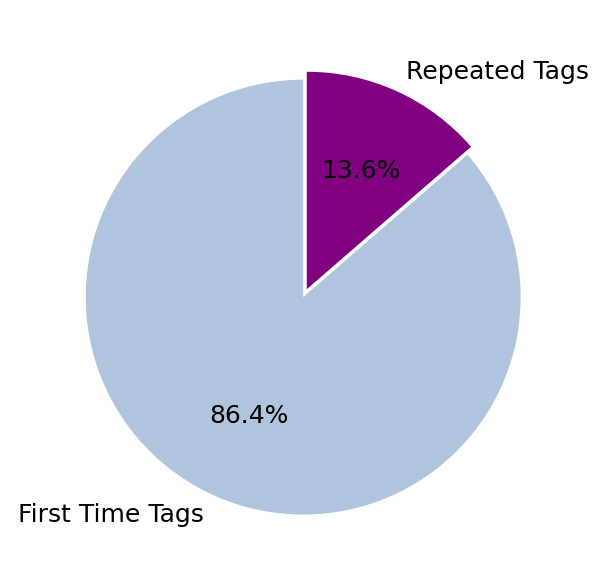

In [15]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['lightsteelblue', "purple"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

In [16]:
repeated_tags_rate = round(sum(np.array(counts['message']) > 1)*100/len(counts['message']), 1)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

13.6 percent of the data are from repeated tags


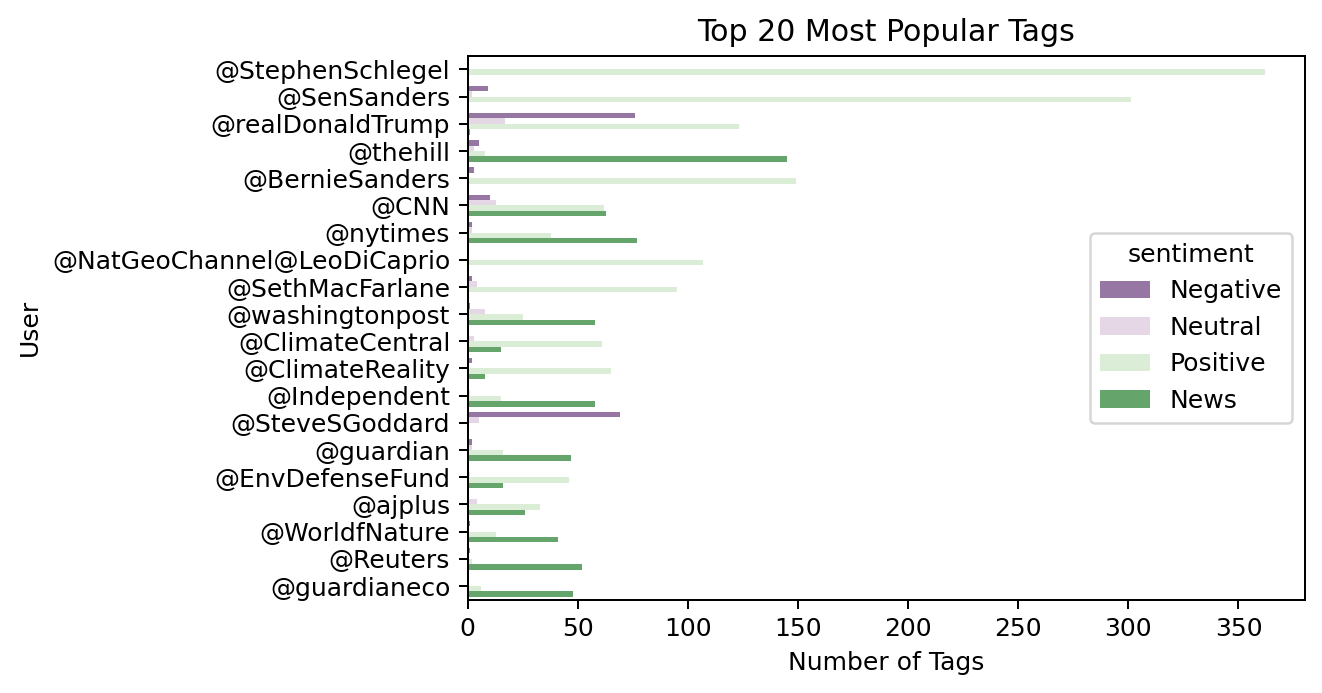

In [17]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df, palette='PRGn',
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

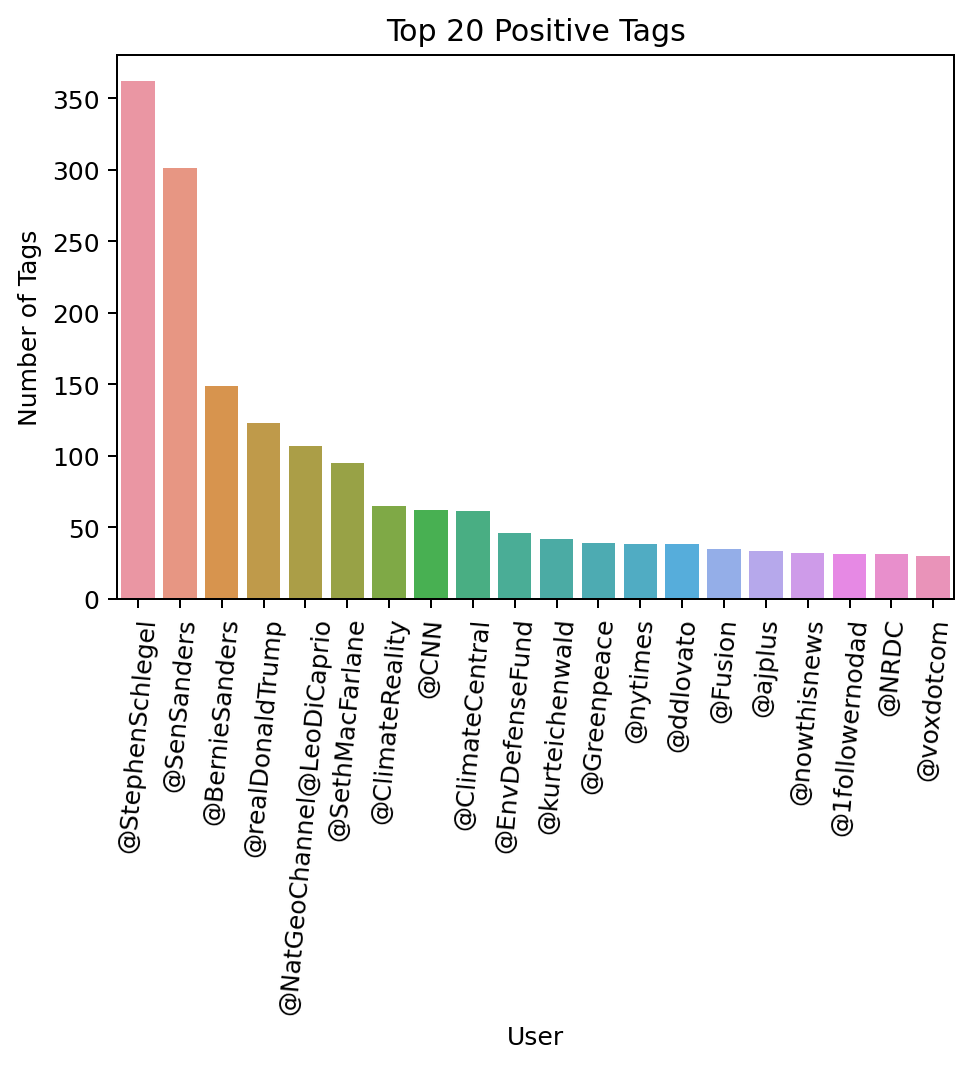

In [18]:
#Now that we've had a look at the tweets themselves as well as the users, we now analyse the hastags:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Positive'],
              order=working_df[working_df['sentiment'] == 'Positive'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Positive Tags')
plt.xticks(rotation=85)
plt.show()

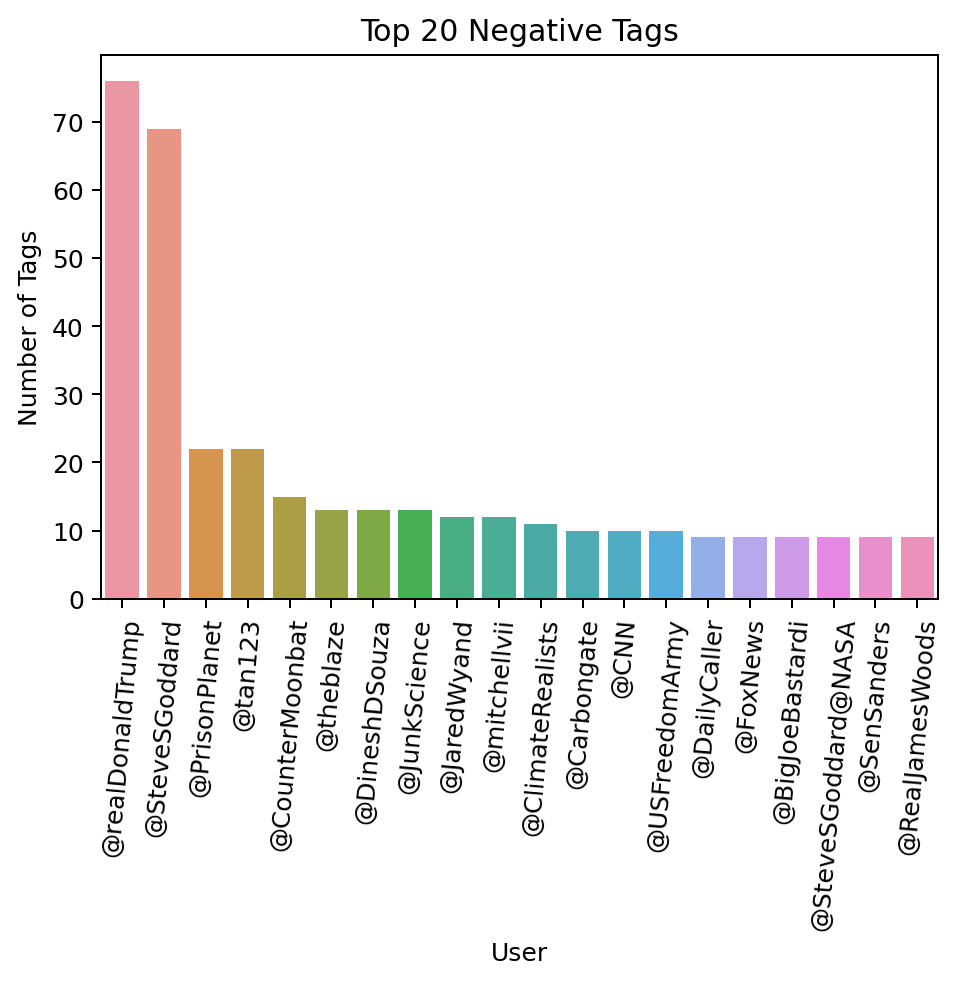

In [19]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

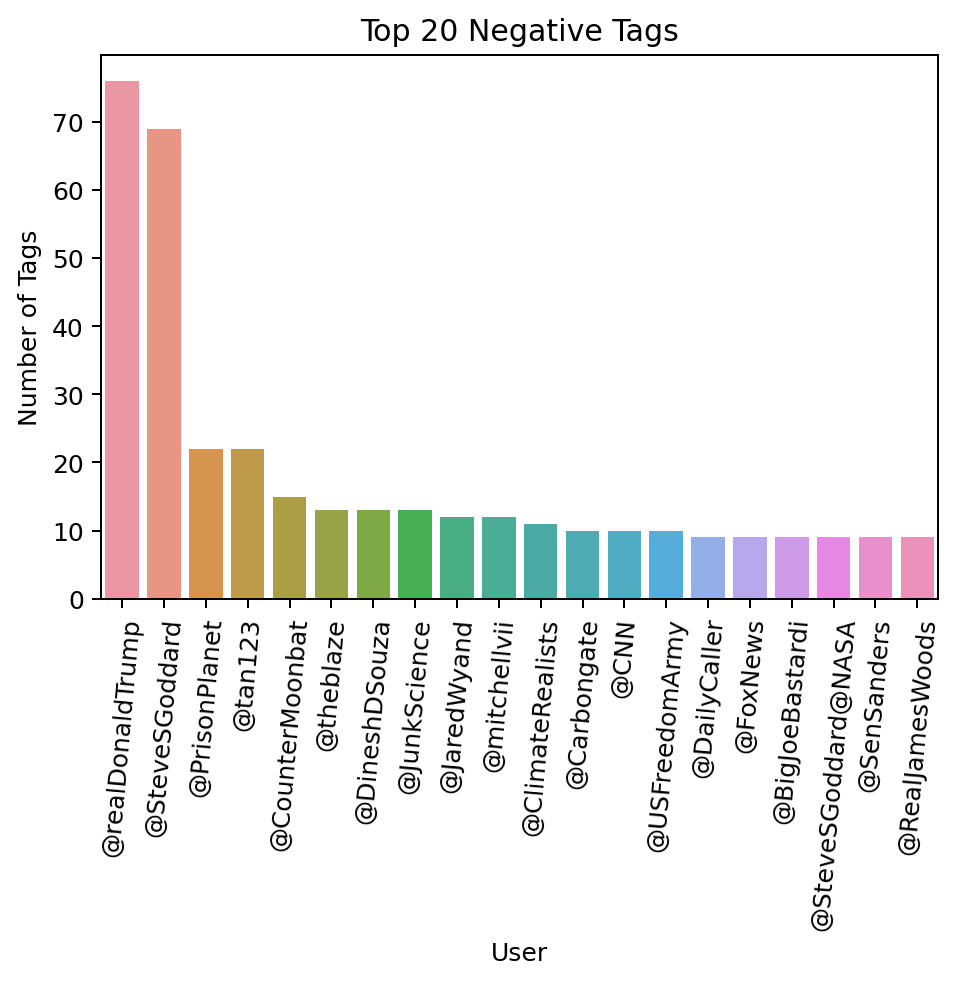

In [20]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

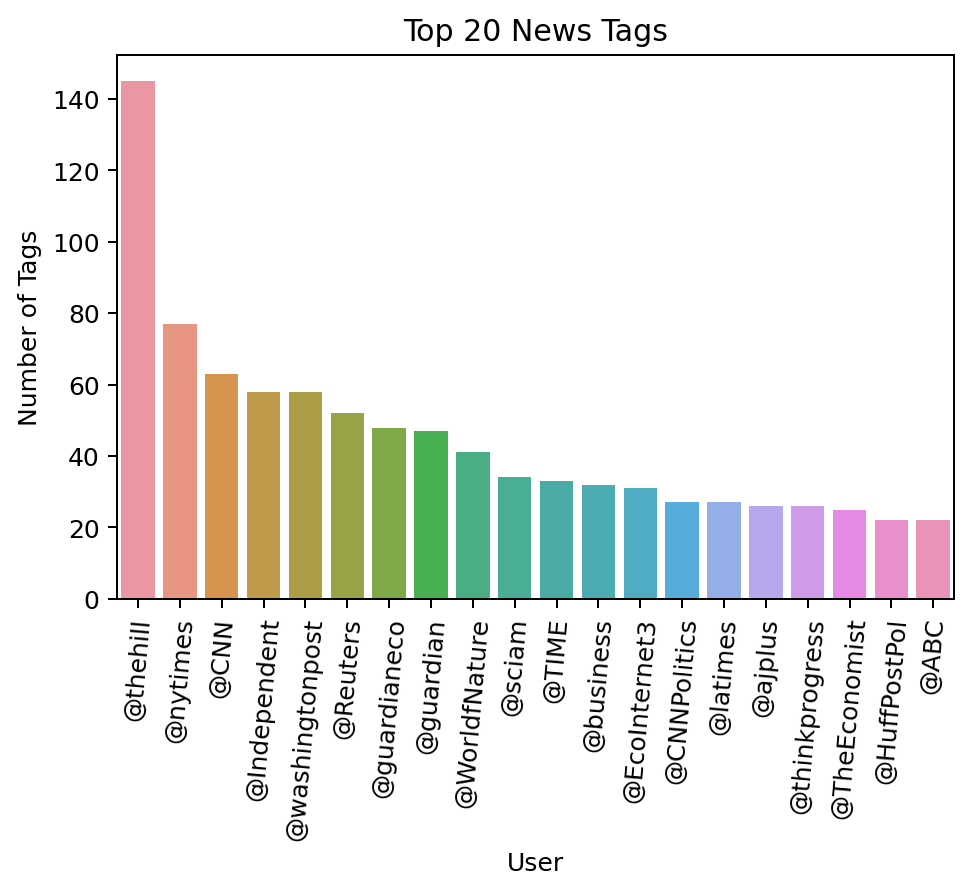

In [21]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'News'],
              order=working_df[working_df['sentiment'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

## Model Building

In [39]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# NLP Libraries
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
import string
import pickle

Data preprocessing

In [17]:
def data_preprocessing(df):
    lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    stopWords = set(stopwords.words('english'))
    
    for tweet in df['message']:
        
        onlyWords = re.sub('[^a-zA-Z]', ' ', tweet)     #keeping only words
        url = re.compile(r'https?://\S+|www\.\S+')      #removing URLs
        review_ = url.sub(r'',onlyWords)
        html=re.compile(r'<.*?>')
        review_ = html.sub(r'',review_)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"     # emoticons
                           u"\U0001F300-\U0001F5FF"     # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"     # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"     # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        
        review_ = emojis.sub(r'',review_)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review_)
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stopWords]
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        
    return df

In [18]:
# Preprocessing the data
train_df = data_preprocessing(train_df)
test_df = data_preprocessing(test_df)

In [20]:
train_df

,sentiment,message,tweetid,tweet tokens
0,1,polyscimajor epa chief doesn t think carbon di...,625221,"[polyscimajor, epa, chief, think, carbon, diox..."
1,1,it s not like we lack evidence of anthropogeni...,126103,"[like, lack, evidence, anthropogenic, global, ..."
2,2,rt rawstory researchers say we have three ye...,698562,"[rt, rawstory, researcher, say, three, year, a..."
3,1,todayinmaker wired was a pivotal year in...,573736,"[todayinmaker, wired, pivotal, year, war, clim..."
4,1,rt soynoviodetodas it s and a racist sex...,466954,"[rt, soynoviodetodas, racist, sexist, climate,..."
...,...,...,...,...
15814,1,rt ezlusztig they took down the material on ...,22001,"[rt, ezlusztig, took, material, global, warmin..."
15815,2,rt washingtonpost how climate change could b...,17856,"[rt, washingtonpost, climate, change, could, b..."
15816,0,notiven rt nytimesworld what does trump act...,384248,"[notiven, rt, nytimesworld, trump, actually, b..."
15817,-1,rt hey liberals the climate change crap is...,819732,"[rt, hey, liberal, climate, change, crap, hoax..."


In [21]:
#features and the label
X = train_df['tweet tokens']
y = train_df['sentiment']

In [22]:
# Tranforming the dataset
data = train_df['tweet tokens']
corpus = [' '.join(i) for i in data] #create your corpus here
vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
X = vectorizer.fit_transform(corpus)

In [23]:
X

<15819x19889 sparse matrix of type '<class 'numpy.float64'>'
	with 175274 stored elements in Compressed Sparse Row format>

# Logistic Regression

This a type of regression that uses an S-shaped curve called Sigmoid to squeeze the range of output values to exist only between 0 and 1.
It has a point of inflection, which can be used to separate the feature space into two distinct areas (one for each class).
It has shallow gradients at both its top and bottom, which can be mapped to zeroes or ones respectively with little ambiguity.

In [24]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scikit_log_reg = LogisticRegression(solver='liblinear',random_state=42)
LogisticRegression_model=scikit_log_reg.fit(X_train, y_train)

In [25]:
# Predictions
y_pred = LogisticRegression_model.predict(X_test)

In [26]:
# Evaluating the Logistic Regression model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[  75   29  165    9]
 [   4  121  276   24]
 [   7   36 1619   93]
 [   3   13  216  474]]
              precision    recall  f1-score   support

          -1       0.84      0.27      0.41       278
           0       0.61      0.28      0.39       425
           1       0.71      0.92      0.80      1755
           2       0.79      0.67      0.73       706

    accuracy                           0.72      3164
   macro avg       0.74      0.54      0.58      3164
weighted avg       0.73      0.72      0.70      3164



In [27]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [30]:
pred = LogisticRegression_model.predict(tests_X)
predictions = pred[:]

In [31]:
len(list(predictions))

10546

In [32]:
len(test_df['tweetid'].to_list())

10546

In [33]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions)
    })
submission.to_csv("LogisticRegressionSubmissions.csv", index=False)

In [34]:
#saving model as dump
with open('logisticRegression.pkl', 'wb') as file:
    pickle.dump(LogisticRegression_model,file)

# DecisionTreeClassifier

Decision tree is a non-parametric method for both classification and regression.It breaks down datasets into smaller subsets, while a decision tree structure is formed.The end result is a tree with decision nodes and leaf nodes.A decision node has two or more branches, each representing values for the attribute tested

In [40]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier()
decisionTree_model = clf.fit(X_train,y_train)

In [41]:
# Predictions
y_pred = decisionTree_model.predict(X_test)

In [42]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[  80   44  134   20]
 [  23  137  230   35]
 [  61  171 1309  214]
 [  11   43  220  432]]
              precision    recall  f1-score   support

          -1       0.46      0.29      0.35       278
           0       0.35      0.32      0.33       425
           1       0.69      0.75      0.72      1755
           2       0.62      0.61      0.61       706

    accuracy                           0.62      3164
   macro avg       0.53      0.49      0.50      3164
weighted avg       0.61      0.62      0.61      3164



In [43]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [44]:
pred = decisionTree_model.predict(tests_X)
predictions_DT = pred[:]

In [45]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_DT)
    })
submission.to_csv("DecisionTreeClassifierSubmission.csv", index=False)

In [46]:
#saving model as dump
with open('DecisionTreeClassifier.pkl', 'wb') as file:
    pickle.dump(decisionTree_model,file)

# SVM Classifier

In [47]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = svm.SVC(kernel='linear') # Linear Kernel
SVM_model = clf.fit(X_train, y_train)

In [48]:
# Predictions
y_pred = SVM_model.predict(X_test)

In [49]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[ 115   33  125    5]
 [   9  166  232   18]
 [  16   68 1557  114]
 [   6   21  172  507]]
              precision    recall  f1-score   support

          -1       0.79      0.41      0.54       278
           0       0.58      0.39      0.47       425
           1       0.75      0.89      0.81      1755
           2       0.79      0.72      0.75       706

    accuracy                           0.74      3164
   macro avg       0.72      0.60      0.64      3164
weighted avg       0.74      0.74      0.73      3164



In [50]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [51]:
pred = SVM_model.predict(tests_X)
predictions_SVM = pred[:]

In [53]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_SVM)
    })
submission.to_csv("LinearSVM_Submission.csv", index=False)

In [54]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)#saving model as dump
with open('LinearSVM.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

# GaussianNB

An implemenation of one of the Naive bayes methods.It is suitable to features that follow normal distribution

In [56]:
# Spliting the datasets and training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = GaussianNB()
X_train = X_train.todense()
GaussianNB_model = model.fit(X_train, y_train)

In [58]:
# Predictions
X_test = X_test.todense()
y_pred = GaussianNB_model.predict(X_test)

In [59]:
# Evaluating the model performance
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[136  36  89  17]
 [102 120 129  74]
 [234 230 949 342]
 [ 84  29 136 457]]
              precision    recall  f1-score   support

          -1       0.24      0.49      0.33       278
           0       0.29      0.28      0.29       425
           1       0.73      0.54      0.62      1755
           2       0.51      0.65      0.57       706

    accuracy                           0.53      3164
   macro avg       0.44      0.49      0.45      3164
weighted avg       0.58      0.53      0.54      3164



In [60]:
# Predicting on the test.csv
test_ = test_df['tweet tokens']
corpus = [' '.join(i) for i in test_]
tests_X = vectorizer.transform(corpus)

In [62]:
tests_X = tests_X.todense()
pred = GaussianNB_model.predict(tests_X)
predictions_GaussianNB = pred[:]

In [63]:
#creating kaggle submission
submission = pd.DataFrame(
    {'tweetid': test_df['tweetid'].to_list(),
     'sentiment': list(predictions_GaussianNB)
    })
submission.to_csv("GaussianNB_Submission.csv", index=False)

In [64]:
#saving model as dump
with open('GaussianNB.pkl', 'wb') as file:
    pickle.dump(SVM_model,file)

# MultinomialNB

## Model Deployment